#0. Background Info

kaggle's case:

Titanic - Machine Learning from Disaster

information link:https://www.kaggle.com/c/titanic/overview




In [1]:
# import package
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# 1. Load the data

In [2]:
#Load the data
data1 = pd.read_csv("train.csv")
data2 = pd.read_csv("test.csv")
data3 = pd.read_csv("gender_submission.csv")
data4=pd.merge(data3,data2)
data=pd.concat([data1,data4],axis=0)
data=data.reset_index()
data.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Pre-process the data (aka data wrangling)

1, Data cleanning

In [3]:
# drop the unrelated columns
data.drop(['PassengerId','Cabin','Ticket'],axis=1,inplace=True)
data.head()

,index,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


2, Identification and treatment of missing values and outliers.

In [4]:
# find the missing value
data.isnull().sum()

index         0
Survived      0
Pclass        0
Name          0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

In [5]:
#Find the null value in Fare catergory and fill with mean value
data[data['Embarked'].isnull()]

,index,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [6]:
# Miss. Amelie and Mrs. George Nelson was embarked with 'S',since the search from 
#https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html
data['Embarked'] = data['Embarked'].fillna('S')

In [7]:
data.corr()

,index,Survived,Pclass,Age,SibSp,Parch,Fare
index,1.000000,0.001504,-0.018212,0.012723,-0.027343,0.003911,-0.003723
Survived,0.001504,1.000000,-0.264710,-0.053695,0.002370,0.108919,0.233622
Pclass,-0.018212,-0.264710,1.000000,-0.408106,0.060832,0.018322,-0.558629
Age,0.012723,-0.053695,-0.408106,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.027343,0.002370,0.060832,-0.243699,1.000000,0.373587,0.160238
Parch,0.003911,0.108919,0.018322,-0.150917,0.373587,1.000000,0.221539
Fare,-0.003723,0.233622,-0.558629,0.178740,0.160238,0.221539,1.000000


In [8]:
# find the missing value in fare column
data[data['Fare'].isnull()]

,index,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
1043,152,0,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,S


In [9]:
#fill NA value within "Fare" column
data['Fare'] = data['Fare'].fillna(data.groupby(['Pclass'])['Fare'].mean()[3])

In [10]:
# Since ['age'] has no large empty value,
#so fill the age with mean value
data['Age'].fillna(data['Age'].mean(), inplace = True)

In [11]:
# Check each numerical,compare the mean,max,min
data.describe()

,index,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,369.478992,0.377387,2.294882,29.881138,0.498854,0.385027,33.280206
std,248.767105,0.484918,0.837836,12.883193,1.041658,0.865560,51.741830
min,0.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,163.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,327.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200
75%,563.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,890.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


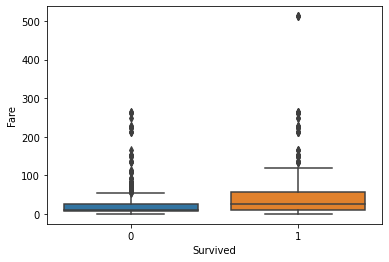

In [12]:
# for the descibe table, the fare have the outlier more 400
sns.boxplot(x="Survived", y="Fare", data=data)

In [13]:
# Remove the outlier of Fare with more than 400
data.drop(data[data.Fare > 400].index, inplace=True)

3, Feature engineering


In [14]:
# encoding the sex (categorical variable)
table1=pd.get_dummies(data['Sex'])
data=pd.concat([data, table1], axis=1)

In [15]:
# encoding the embarked (categorical variable)
table2=pd.get_dummies(data['Embarked'])
data=pd.concat([data, table2], axis=1)

# 3. Exploratory data analysis.

1, At least two plots describing different aspects of the data set (e.g. identifying outliers, histograms of different distributions, or scatter plots to explore correlations).

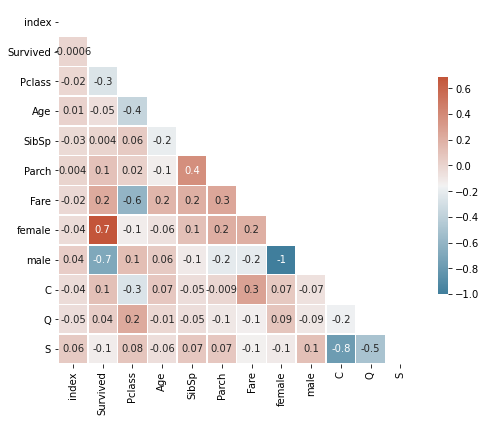

In [16]:
# heatmap for correlations
table3=data.drop(['Name','Sex','Embarked'],axis=1)
plt.figure(figsize=(8,8))
sns.heatmap(table3.astype(float).corr(), mask=np.triu(table3.astype(float).corr()), cmap = sns.diverging_palette(230, 20, as_cmap=True), annot=True, fmt='.1g', square=True, linewidths=.5, cbar_kws={"shrink": .5})

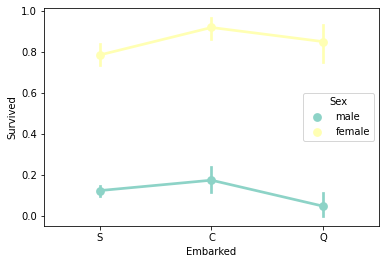

In [17]:
#the relationship between survival and categorical datad catergircal data(sex,Embarked)
sns.pointplot(x="Embarked", y="Survived", hue="Sex", kind="box", data=data,palette="Set3")

2, Print a basic data description (e.g. number of examples, number features, number of examples in each class and such).

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1305 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1305 non-null   int64  
 1   Survived  1305 non-null   int64  
 2   Pclass    1305 non-null   int64  
 3   Name      1305 non-null   object 
 4   Sex       1305 non-null   object 
 5   Age       1305 non-null   float64
 6   SibSp     1305 non-null   int64  
 7   Parch     1305 non-null   int64  
 8   Fare      1305 non-null   float64
 9   Embarked  1305 non-null   object 
 10  female    1305 non-null   uint8  
 11  male      1305 non-null   uint8  
 12  C         1305 non-null   uint8  
 13  Q         1305 non-null   uint8  
 14  S         1305 non-null   uint8  
dtypes: float64(2), int64(5), object(3), uint8(5)
memory usage: 158.5+ KB


3, Print (or include in the plots) descriptive statistics (e.g. means, medians, standard deviation)

In [19]:
data.describe()

,index,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
count,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000
mean,369.065900,0.375479,2.298851,29.847057,0.500383,0.384674,31.811857,0.355556,0.644444,0.203831,0.094253,0.701916
std,248.772213,0.484432,0.836040,12.876700,1.042888,0.866421,44.489559,0.478865,0.478865,0.403000,0.292292,0.457592
min,0.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000
50%,326.000000,0.000000,3.000000,29.881138,0.000000,0.000000,14.454200,0.000000,1.000000,0.000000,0.000000,1.000000
75%,562.000000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,9.000000,263.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 4. Partition data into train, validation and test sets.

From Lecture06.slide:\
training set:   60% of total data set   1305*0.6= 783  \
Validation set: 20% of total data set 1305*0.2 = 261    \
Testing setzz:  20% of total data set   1305*0.2=261

In [20]:
train_data=data[:783]
valid_data=data[783:1044]
test_data=data[1044:]

# 5. Fit models on the training set (this can include a hyper-parameter search) and select the best based on validation set performance.

1，building the machine learning model for both test and valid data

In [21]:
def build_x(df):
    return StandardScaler().fit_transform(df.drop(columns=['Name','Sex','Embarked','index','Survived']))

In [22]:
train_x=build_x(train_data)
valid_x=build_x(valid_data)
test_x=build_x(test_data)

In [23]:
train_y = train_data['Survived'].values
valid_y = valid_data['Survived'].values
test_y  =  test_data['Survived'].values

2, runing into different model

In [24]:
#Decision Tree Classifier
parameters={'criterion':('gini','entropy'),
            'splitter':('random','best'),'max_depth':range(1,5)}
clf=tree.DecisionTreeClassifier(random_state=30)
clf_gs=GridSearchCV(clf,parameters)
clf_gs=clf_gs.fit(train_x,train_y)
clf_score=clf_gs.score(valid_x,valid_y)

In [25]:
#Random Forest Classifier
parameters={'criterion':('gini','entropy'),
            'max_features':('auto','sqrt','log2'),'max_depth':range(1,5)}
random_forest=RandomForestClassifier()
random_forest_rs=RandomizedSearchCV(random_forest,parameters)
random_forest_rs=random_forest_rs.fit(train_x,train_y)
random_forest_score=random_forest_rs.score(valid_x,valid_y)

In [26]:
#Gradient Boosting Classifier
Gradient_Boosting=GradientBoostingClassifier().fit(train_x,train_y)
Gradient_Boosting_score=Gradient_Boosting.score(valid_x,valid_y)

In [27]:
#Logistic Regression
parameters={'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
logis_R=LogisticRegression()
logis_R_gs=GridSearchCV(logis_R,parameters)
logis_R_gs=logis_R_gs.fit(train_x,train_y)
logis_R_score=logis_R_gs.score(valid_x,valid_y)

In [28]:
#Gaussian Naive Bayes(GNB)
GNB=GaussianNB().fit(train_x,train_y)
GNB.score=GNB.score(valid_x,valid_y)

In [29]:
#Stochastic Gradient Descent (SGD)
parameters={'loss':('deviance','exponential'),'learning_rate':[0.01,0.05,0.1,0.2],'n_estimators':[50,100,150]}
SGD=GradientBoostingClassifier()
SGD_gs=GridSearchCV(SGD,parameters)
SGD_gs=SGD_gs.fit(train_x,train_y)
SGD_score=SGD_gs.score(valid_x,valid_y)
SGD_score

0.8505747126436781

In [30]:
#xgboost
Xgboost=XGBClassifier().fit(train_x,train_y)
Xgboost_score=Xgboost.score(valid_x,valid_y)

3, select the table from best performance of validation 

In [31]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest Classifier','Gradient Boosting',
              'Logistic Regression','Gaussian Naive Bayes','Stochastic Gradient Decent', 
              'xgbooste'],
    'Score': [clf_score,random_forest_score,Gradient_Boosting_score,
              logis_R_score,GNB.score,SGD_score,Xgboost_score]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
print(result_df)

                               Model
Score                               
0.915709    Random Forest Classifier
0.892720        Gaussian Naive Bayes
0.885057         Logistic Regression
0.865900               Decision Tree
0.865900           Gradient Boosting
0.858238                    xgbooste
0.850575  Stochastic Gradient Decent


# 6. Print the results of the final model on the test set. This should include accuracy, F1-score and AUC.

In [32]:
#find the predicted value from test_data
Y_prediction = random_forest_rs.predict(test_x)

In [33]:
#Accuracy
accuracy=accuracy_score(test_y, Y_prediction)
print('accuracy:', accuracy)

accuracy: 0.9693486590038314


In [34]:
# F1-score
f1_score=f1_score(test_y, Y_prediction)
print('F1 score:',f1_score )

F1 score: 0.9574468085106385


In [35]:
# AUC score
y_scores = random_forest_rs.predict_proba(test_x)[:,1]
r_a_score = roc_auc_score(test_y, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9959867499044465


In [36]:
Final_result = pd.DataFrame({
    'Indicator': ['Accuracy','F1 score','AUC Score'],
    'Score': [accuracy,f1_score,r_a_score]})
print(Final_result)

   Indicator     Score
0   Accuracy  0.969349
1   F1 score  0.957447
2  AUC Score  0.995987
